Muhammad Irfansyah Adam
; 1306622055
; Fisika A
; Eksperimen Fisika

Analisis Tren Perubahan Suhu Berdasarkan Data Iklim Harian BMKG dengan Metode 
Regresi Linear pada Python

Data Berhasil disimpan ke Data_Bersih.xlsx


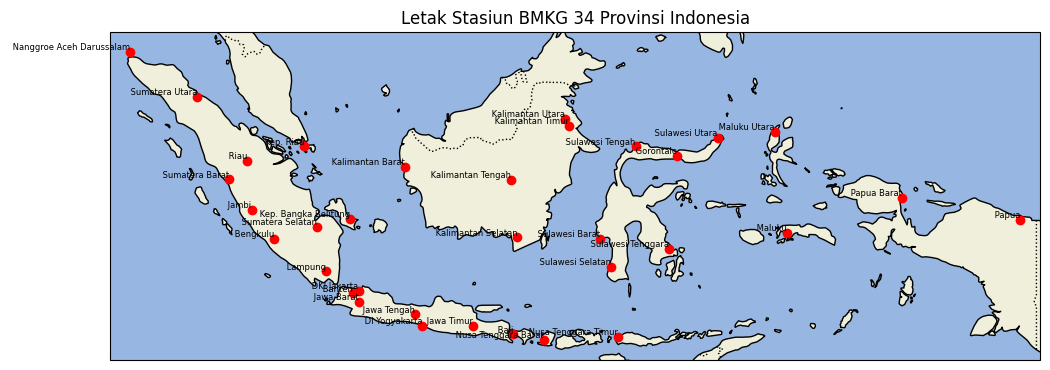

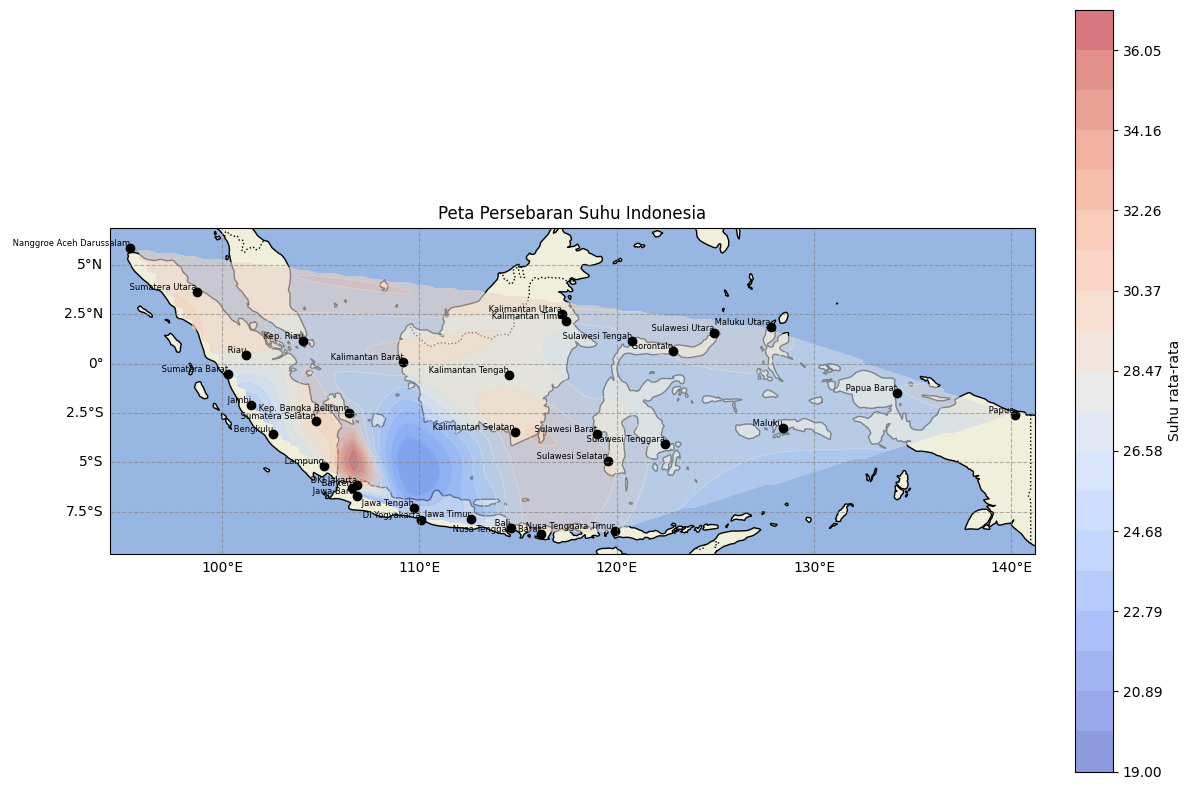

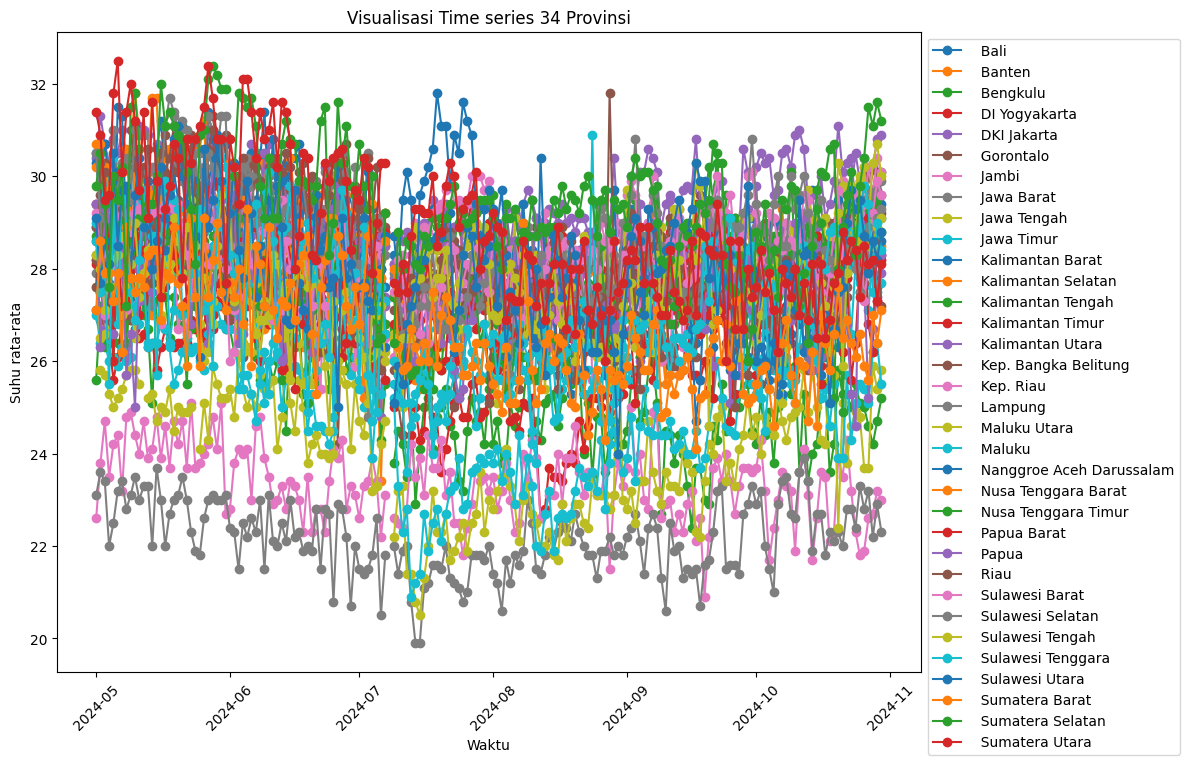

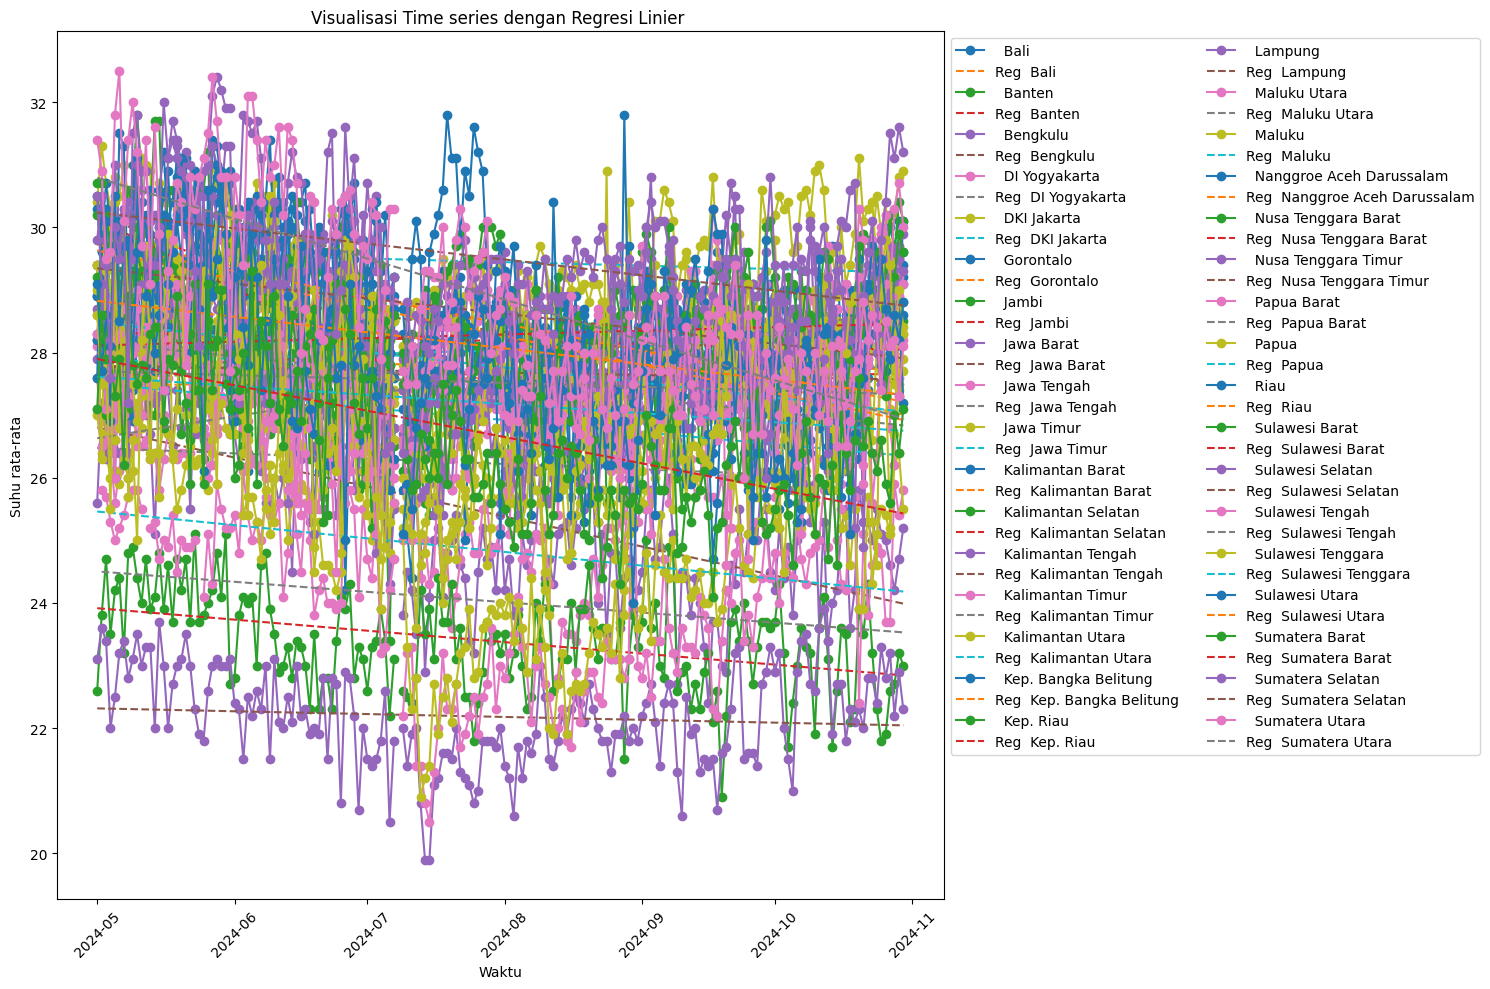

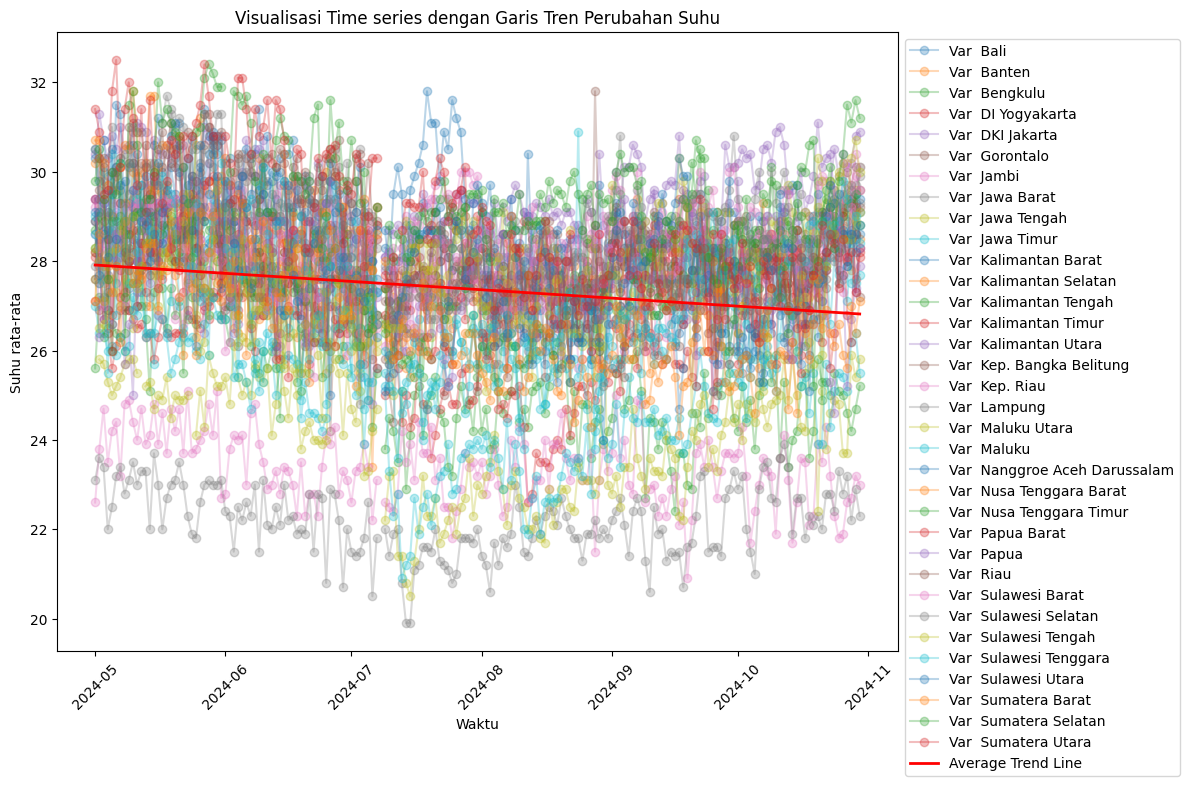

Interpretasi Koefisien:
Slope (Kemiringan): -0.0060 menunjukkan perubahan rata-rata per unit waktu.
Intercept: 4476.6922 menunjukkan nilai prediksi saat waktu = 0 (awal ordinal).

Evaluasi Model:
Mean Squared Error (MSE): 4.0411
R-squared (R2): 0.0247 menunjukkan proporsi variasi yang dijelaskan oleh model.


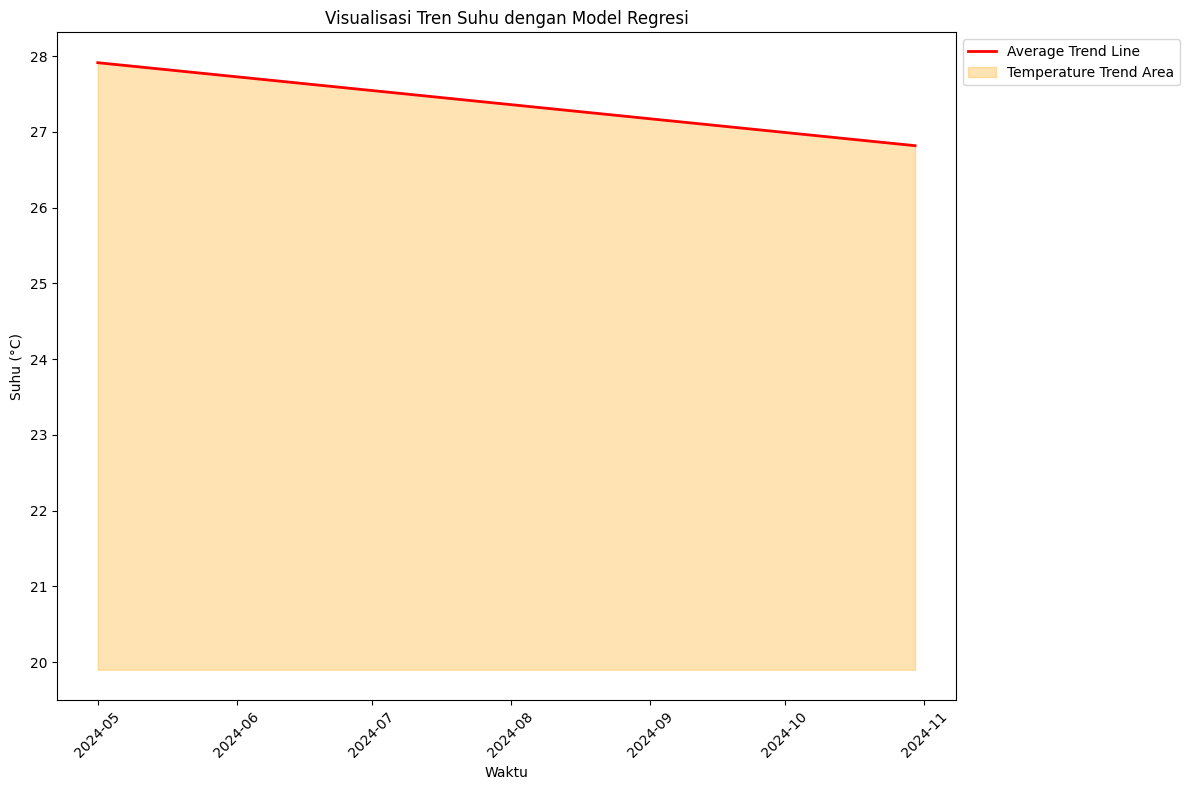

In [1]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


def process_file(file_path):
    try:
        # Membaca metadata
        head = pd.read_excel(file_path, usecols="C", nrows=5, header=None)
        head.iloc[:, 0] = head.iloc[:, 0].str.replace(": ", "", regex=False)
        station_id = head.iloc[0, 0]
        station_name = head.iloc[1, 0]
        latitude = float(head.iloc[2, 0])
        longitude = float(head.iloc[3, 0])
        elevation = float(head.iloc[4, 0])

        # Membaca data, termasuk kolom tanggal
        data = pd.read_excel(file_path, usecols="A:K", skiprows=8, nrows=183)
        
        # Menghilangkan data yang tidak dapat terbaca
        kolom_target = 'Tavg'  
        data[kolom_target] = data[kolom_target].astype(str).str.replace('-', 'nan', regex=False)
        
        # Pastikan data tidak kosong
        if data.empty:
            print(f"File {file_path} tidak memiliki data.")
            return None

        # Mengambil tanggal dari kolom A
        dates = data.iloc[:, 0]

        # Periksa apakah ada tanggal kosong atau duplikat
        if dates.isnull().any():
            print(f"File {file_path} memiliki tanggal kosong.")
            return None

        if dates.duplicated().any():
            print(f"File {file_path} memiliki tanggal duplikat.")
            return None

        # Mengambil data relevan setelah baris "Keterangan :"
        keterangan_index = data[data.iloc[:, 0].str.contains("Keterangan : ", na=False)].index
        if not keterangan_index.empty:
            last_row_index = keterangan_index[0] - 4
            relevant_data = data.loc[last_row_index:]
        else:
            relevant_data = data

        # Transpose data
        data_transposed = relevant_data.T

        # Mengambil header dan data Tavg
        headers = data_transposed.iloc[0].values
        tavg_data = data_transposed.iloc[3].values
        rr_data = data_transposed.iloc[5].values
        ff_x_data = data_transposed.iloc[7].values
        ddd_x_data = data_transposed.iloc[8].values

        # Membuat DataFrame untuk data Tavg
        tavg_df = pd.DataFrame([tavg_data])
        rr_df = pd.DataFrame([rr_data])
        ff_x_df = pd.DataFrame([ff_x_data])
        ddd_x_df = pd.DataFrame([ddd_x_data])

        # Membuat DataFrame metadata
        metadata = {
            'station_id': [station_id],
            'station_name': [station_name],
            'latitude': [latitude],
            'longitude': [longitude],
            'elevation': [elevation]
        }
        metadata_df = pd.DataFrame(metadata)

        # Menambahkan tanggal sebagai kolom
        tavg_df.columns = dates.values  # Menggunakan dates sebagai header kolom
        rr_df.columns = dates.values
        ff_x_df.columns = dates.values
        ddd_x_df.columns = dates.values

        # Menggabungkan metadata dan data Tavg
        combined_data_tavg = pd.concat([metadata_df, tavg_df], axis=1)
        combined_data_rr = pd.concat([metadata_df, rr_df], axis=1)
        combined_data_ff_x = pd.concat([metadata_df, ff_x_df], axis=1)
        combined_data_ddd_x = pd.concat([metadata_df, ddd_x_df], axis =1)

        return combined_data_tavg, combined_data_rr, combined_data_ff_x, combined_data_ddd_x

    except Exception as e:
        print(f"Error saat memproses file {file_path}: {e}")
        return None, None, None

# Menentukan pola file dengan wildcard
file_pattern = r'data\*.xlsx'
files = glob.glob(file_pattern)

# Filter file sementara Excel yang diawali '~$'
files = [file for file in files if not os.path.basename(file).startswith('~$')]
all_tavg_data = []
all_rr_data = []
all_ff_x_data = []
all_ddd_x_data = []


# Iterasi melalui daftar file
for file in files:
    tavg_df, rr_df, ff_x_df, ddd_x_df = process_file(file)
    if tavg_df is not None:
        all_tavg_data.append(tavg_df)
        all_rr_data.append(rr_df)
        all_ff_x_data.append(ff_x_df)
        all_ddd_x_data.append(ddd_x_df)

# Menggabungkan semua DataFrame jika ada data valid
if all_tavg_data:
    final_combined_tavg = pd.concat(all_tavg_data, ignore_index=True)
    final_combined_rr = pd.concat(all_rr_data, ignore_index=True)
    final_combined_ff_x = pd.concat(all_ff_x_data, ignore_index=True)
    final_combined_ddd_x = pd.concat(all_ddd_x_data, ignore_index=True)
    output_file = r'Data_Bersih.xlsx'

    with pd.ExcelWriter(output_file) as writer:
        final_combined_tavg.to_excel(writer, sheet_name='Tavg', index=False) 
        final_combined_rr.to_excel(writer, sheet_name='RR', index =False)
        final_combined_ff_x.to_excel(writer, sheet_name='ff_x', index=False)
        final_combined_ddd_x.to_excel(writer, sheet_name='ddd_x', index=False)

# Menampilkan hasil
    print(f"Data Berhasil disimpan ke {output_file}")
else:
    print("Tidak ada data yang valid untuk digabungkan.")



# Membaca data dari file Excel
file_path = 'Data_Bersih.xlsx'

df1 = pd.read_excel(file_path, 'Tavg')

# Mengambil kolom latitude, longitude, dan station_name
latitudes = df1['latitude']
longitudes = df1['longitude']
station_names = df1['station_name']

# Membuat plot peta stasiun
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Menambahkan fitur geografis
ax.add_feature(cfeature.LAND, zorder=1)
ax.add_feature(cfeature.OCEAN, zorder=1)
ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=1)
ax.add_feature(cfeature.COASTLINE, zorder=1)

# Menentukan rentang peta menggunakan nilai min/max dari longitude dan latitude
ax.set_extent([min(longitudes)-1, max(longitudes)+1, min(latitudes)-1, max(latitudes)+1], crs=ccrs.PlateCarree())

# Menampilkan lokasi stasiun dengan marker
ax.scatter(longitudes, latitudes, color='red', marker='o', label='Stasiun', transform=ccrs.PlateCarree(), zorder=2)

# Tambahkan nama stasiun dengan ukuran font yang kecil
for i in range(len(latitudes)):
    plt.text(longitudes[i], latitudes[i], station_names[i], fontsize=6, ha='right', va='bottom', transform=ccrs.PlateCarree())

# Atur plot
plt.title('Letak Stasiun BMKG 34 Provinsi Indonesia')
plt.show()    



# Membaca data dari file Excel
file_path = 'Data_Bersih.xlsx'
df1 = pd.read_excel(file_path, 'Tavg')
df2 = pd.read_excel(file_path, 'ff_x')
df3 = pd.read_excel(file_path, 'ddd_x')

# Mengambil kolom latitude, longitude, dan station_name
latitudes = df1['latitude']
longitudes = df1['longitude']
station_names = df1['station_name']

# Mengonversi kolom menjadi format datetime
df1.columns = pd.to_datetime(df1.columns, format='%d-%m-%Y', errors='coerce')

# Menghapus kolom yang tidak dapat dikonversi menjadi tanggal
df1 = df1.loc[:, df1.columns.notnull()]
df2 = df2.loc[:, df2.columns.notnull()]
df3 = df3.loc[:, df3.columns.notnull()]

# Hanya gunakan kolom numeric
df1_numeric = df1.select_dtypes(include=[np.number])
df2_numeric = df2.select_dtypes(include=[np.number])
df3_numeric = df3.select_dtypes(include=[np.number])

# Menghitung rata-rata suhu
tavg_mean = df1_numeric.mean(axis=1)

# Menetapkan levels secara manual 
levels = np.linspace(19, 37, 20)  

# Data valid (tanpa NaN)
lat = latitudes.to_numpy()
lon = longitudes.to_numpy()
tavg = tavg_mean.to_numpy()
station_names_valid = station_names.to_numpy()
valid_indices = ~np.isnan(tavg)
lat = lat[valid_indices]
lon = lon[valid_indices]
tavg = tavg[valid_indices]
station_names_valid = station_names_valid[valid_indices]


# Menambahkan suhu dengan interpolasi
grid_x, grid_y = np.mgrid[min(lon):max(lon):100j, min(lat):max(lat):100j]
grid_tavg = griddata((lon, lat), tavg, (grid_x, grid_y), method='cubic')
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.LAND, zorder=1)
ax.add_feature(cfeature.OCEAN, zorder=1)
ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=1)
ax.add_feature(cfeature.COASTLINE, zorder=1)

# Set extent menggunakan nilai min/max dari longitude dan latitude
ax.set_extent([min(lon)-1, max(lon)+1, min(lat)-1, max(lat)+1], crs=ccrs.PlateCarree())
contour = ax.contourf(grid_x, grid_y, grid_tavg, levels=levels, cmap='coolwarm', alpha=0.6, vmin=19, vmax=37, transform=ccrs.PlateCarree())
ax.scatter(lon, lat, color='black', marker='o', label='Data Points', transform=ccrs.PlateCarree(), zorder=2)
cbar = plt.colorbar(contour, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Suhu rata-rata')
gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.6)
gl.right_labels = False
gl.top_labels = False


# Menambahkan nama stasiun 
for i in range(len(lat)):
    plt.text(lon[i], lat[i], station_names_valid[i], fontsize=6, ha='right', va='bottom')

# Atur plot
plt.title('Peta Persebaran Suhu Indonesia')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()



# Path ke file Excel
file_path = 'Data_Bersih.xlsx'

# Baca data dari file Excel
df = pd.read_excel(file_path)

# Menyiapkan plot
plt.figure(figsize=(12,8))  

# Iterasi untuk setiap baris dalam data, mulai dari baris ke-1
for i in range(34):  
    time_series_data = df.iloc[i, 5:] 
    dates = df.columns[5:]  

    # Ubah kolom tanggal menjadi format datetime
    dates = pd.to_datetime(dates, dayfirst=True)

    # Mengonversi time_series_data menjadi numerik, mengganti kesalahan dengan nan
    time_series_data = pd.to_numeric(time_series_data, errors='coerce')

    # Plot masing-masing variabel
    plt.plot(dates, time_series_data, marker='o', label=f' {df.iloc[i, 1]}')

# Penyesuaian tampilan grafik
plt.ylim() 
plt.xticks(rotation=45) 
plt.xlabel('Waktu')
plt.ylabel('Suhu rata-rata')
plt.title('Visualisasi Time series 34 Provinsi')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
plt.tight_layout()

# Tampilkan plot
plt.show()



# Path ke file Excel
file_path = 'Data_Bersih.xlsx'

# Baca data dari file Excel
df = pd.read_excel(file_path)

# Menyiapkan plot
plt.figure(figsize=(15, 10))  

# Iterasi untuk setiap baris dalam data, mulai dari baris ke-1
for i in range(34):  
    time_series_data = df.iloc[i, 5:] 
    dates = df.columns[5:]

    # Ubah kolom tanggal menjadi format datetime
    dates = pd.to_datetime(dates, dayfirst=True)

    # Mengonversi time_series_data menjadi numerik, mengganti kesalahan dengan nan
    time_series_data = pd.to_numeric(time_series_data, errors='coerce')

    # Hilangkan nilai nan untuk regresi linear
    valid_indices = ~time_series_data.isna()
    valid_dates = dates[valid_indices]
    valid_data = time_series_data[valid_indices]

    # Konversi tanggal menjadi ordinal untuk regresi linear
    ordinal_dates = valid_dates.map(lambda x: x.toordinal()).values.reshape(-1, 1)
    valid_data = valid_data.values.reshape(-1, 1)

    # Buat model regresi linear
    model = LinearRegression()
    model.fit(ordinal_dates, valid_data)

    # Prediksi nilai regresi
    predicted_values = model.predict(ordinal_dates)

    # Plot data asli
    plt.plot(dates, time_series_data, marker='o', label=f' {df.iloc[i, 1]}')

    # Plot garis regresi
    plt.plot(valid_dates, predicted_values, linestyle='--', label=f'Reg {df.iloc[i, 1]}')

# Penyesuaian tampilan grafik
plt.ylim() 
plt.xticks(rotation=45)
plt.xlabel('Waktu')
plt.ylabel('Suhu rata-rata')
plt.title('Visualisasi Time series dengan Regresi Linier ')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2) 
plt.tight_layout()

# Tampilkan plot
plt.show()



# Path ke file Excel
file_path = 'Data_Bersih.xlsx'

# Baca data dari file Excel
df = pd.read_excel(file_path)

# Menyiapkan plot
plt.figure(figsize=(12, 8))  

# Data untuk menghitung rata-rata
all_dates = []
all_values = []

# Iterasi untuk setiap baris (variabel) dalam data, mulai dari baris ke-1
for i in range(34): 
    time_series_data = df.iloc[i, 5:] 
    dates = df.columns[5:] 

    # Ubah kolom tanggal menjadi format datetime
    dates = pd.to_datetime(dates, dayfirst=True)

    # Mengonversi time_series_data menjadi numerik, mengganti kesalahan dengan NaN
    time_series_data = pd.to_numeric(time_series_data, errors='coerce')

    # Hilangkan nilai NaN untuk agregasi
    valid_indices = ~time_series_data.isna()
    valid_dates = dates[valid_indices]
    valid_data = time_series_data[valid_indices]

    # Kumpulkan data untuk regresi rata-rata
    all_dates.extend(valid_dates.map(lambda x: x.toordinal()).values)
    all_values.extend(valid_data.values)

    # Plot data asli
    plt.plot(dates, time_series_data, marker='o', alpha=0.3, label=f'Var {df.iloc[i, 1]}')

# Hitung regresi rata-rata
all_dates = np.array(all_dates).reshape(-1, 1)
all_values = np.array(all_values).reshape(-1, 1)

# Buat model regresi linear untuk rata-rata
average_model = LinearRegression()
average_model.fit(all_dates, all_values)

# Prediksi nilai rata-rata regresi
unique_dates = np.unique(all_dates)
average_predicted = average_model.predict(unique_dates.reshape(-1, 1))

# Konversi ordinal kembali ke datetime
unique_dates = [pd.Timestamp.fromordinal(int(date)) for date in unique_dates]

# Plot garis tren rata-rata
plt.plot(unique_dates, average_predicted, color='red', linewidth=2, label='Average Trend Line')

# Penyesuaian tampilan grafik
plt.ylim()  
plt.xticks(rotation=45) 
plt.xlabel('Waktu')
plt.ylabel('Suhu rata-rata')
plt.title('Visualisasi Time series dengan Garis Tren Perubahan Suhu')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1) 
plt.tight_layout()

# Tampilkan plot
plt.show()

# Analisis Hasil
# Interpretasi Koefisien
slope = average_model.coef_[0][0]
intercept = average_model.intercept_[0]
print(f"Interpretasi Koefisien:")
print(f"Slope (Kemiringan): {slope:.4f} menunjukkan perubahan rata-rata per unit waktu.")
print(f"Intercept: {intercept:.4f} menunjukkan nilai prediksi saat waktu = 0 (awal ordinal).")

# Evaluasi Model
predicted_values = average_model.predict(all_dates)
mse = mean_squared_error(all_values, predicted_values)
r2 = r2_score(all_values, predicted_values)
print("\nEvaluasi Model:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f} menunjukkan proporsi variasi yang dijelaskan oleh model.")



# Path ke file Excel
file_path = 'Data_Bersih.xlsx'

# Baca data dari file Excel
df = pd.read_excel(file_path)

# Menyiapkan plot
plt.figure(figsize=(12, 8))  

# Data untuk menghitung rata-rata
all_dates = []
all_values = []

# Iterasi untuk setiap baris (variabel) dalam data, mulai dari baris ke-1
for i in range(34): 
    time_series_data = df.iloc[i, 5:] 
    dates = df.columns[5:]  

    # Ubah kolom tanggal menjadi format datetime
    dates = pd.to_datetime(dates, dayfirst=True)

    # Mengonversi time_series_data menjadi numerik, mengganti kesalahan dengan NaN
    time_series_data = pd.to_numeric(time_series_data, errors='coerce')

    # Hilangkan nilai NaN untuk agregasi
    valid_indices = ~time_series_data.isna()
    valid_dates = dates[valid_indices]
    valid_data = time_series_data[valid_indices]

    # Kumpulkan data untuk regresi rata-rata
    all_dates.extend(valid_dates.map(lambda x: x.toordinal()).values)
    all_values.extend(valid_data.values)

# Hitung regresi rata-rata
all_dates = np.array(all_dates).reshape(-1, 1)
all_values = np.array(all_values).reshape(-1, 1)

# Buat model regresi linear untuk rata-rata
average_model = LinearRegression()
average_model.fit(all_dates, all_values)

# Prediksi nilai rata-rata regresi
unique_dates = np.unique(all_dates)
average_predicted = average_model.predict(unique_dates.reshape(-1, 1))

# Konversi ordinal kembali ke datetime
unique_dates = [pd.Timestamp.fromordinal(int(date)) for date in unique_dates]

# Plot garis tren rata-rata
plt.plot(unique_dates, average_predicted, color='red', linewidth=2, label='Average Trend Line')

# Menambahkan visualisasi suhu 
plt.fill_between(unique_dates, np.min(all_values), np.squeeze(average_predicted), color='orange', alpha=0.3, label='Temperature Trend Area')

# Penyesuaian tampilan grafik
plt.ylim()  
plt.xticks(rotation=45) 
plt.xlabel('Waktu')
plt.ylabel('Suhu (°C)')
plt.title('Visualisasi Tren Suhu dengan Model Regresi')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)  
plt.tight_layout()

# Tampilkan plot
plt.show()
